# Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from helper_metrics import count_missing_district, count_missing_district_total, save_model, calculate_results, make_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold
from sklearn.metrics         import mean_absolute_error, accuracy_score
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Load data

In [4]:
df = pd.read_csv("data/imputed_data.csv").iloc[:,1:]
df

,date,district,total population,Under-Five Population,GAM,SAM,GAM Prevalence,SAM Prevalence,ipc,rainfall,ndvi,price_of_water,Total alarms,conflicts,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded
0,2017-07-01,Adan Yabaal,65262.96000,13052.59200,4819.01697,1085.97565,0.36920,0.08320,0.18000,19.15667,0.21500,15.00000,2.16667,2.15000,NaN,0.35100,7,False,-0.01820,0
1,2017-07-01,Luuq,100476.76500,20095.35300,8673.15435,1306.19795,0.43160,0.06500,0.21000,24.24000,0.19333,15.00000,7.83333,1.50000,NaN,0.39260,7,False,-0.03900,59
2,2017-07-01,Buur Hakaba,165968.46000,33193.69200,11909.89669,3711.05477,0.35880,0.11180,0.35000,34.94500,0.34833,52.50000,6.16667,4.66667,NaN,0.28860,7,False,-0.07020,24
3,2017-07-01,Marka,282222.76500,56444.55300,20839.32897,4696.18681,0.36920,0.08320,0.17000,23.56500,0.29833,36.50000,11.83333,11.83333,NaN,0.35100,7,False,-0.01820,60
4,2017-07-01,Buuhoodle,71317.71000,14263.54200,4858.16241,1205.26930,0.34060,0.08450,0.37000,19.54000,0.21333,18.55116,2.33333,2.50000,NaN,0.20280,7,False,-0.13780,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,2021-07-01,Belet Xaawo,NaN,29314.59999,9820.00000,1310.00000,0.33499,0.04469,0.15000,36.71667,0.28500,21.68333,3.50000,1.20000,0.38353,NaN,7,NaN,NaN,15
652,2021-07-01,Jilib,NaN,28586.09073,11560.00000,2770.00000,0.40439,0.09690,0.11000,43.30000,0.45333,40.07000,6.16667,2.00000,0.31242,NaN,7,NaN,NaN,51
653,2021-07-01,Caynabo,NaN,16276.00000,3540.00000,270.00000,0.21750,0.01659,0.17000,21.15500,0.19500,19.08040,0.50000,1.00000,0.25746,NaN,7,NaN,NaN,29
654,2021-07-01,Rab Dhuure,NaN,15127.60000,6940.00000,1560.00000,0.45876,0.10312,0.07000,46.20667,0.21667,18.77839,0.16667,1.00000,0.50720,NaN,7,NaN,NaN,66


In [10]:
# Sanity checks
df.isna().sum().sort_values(ascending=False)[:5]

increase_numeric    73
increase            73
next_prevalence     73
prevalence_6lag     73
date                 0
dtype: int64

In [9]:
len(df.district.unique())

73

# Create train and test sets
We must drop nan values in X for the RF model

In [5]:
y = df.next_prevalence.dropna()
X = df.select_dtypes(exclude=["object", "category"]).drop("next_prevalence", axis=1).dropna(axis=1).iloc[:len(y)]

# Subsets

In [6]:
# Function that returns every possible subset (except the empty set) of the input list l
def subsets(l: object) -> object:
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

# Cross Validation Training

In [8]:
74*3

219

In [8]:
# Define search space for number of trees in random forest and depth of trees
num_trees_min = 64
num_trees_max = 128

depth_min = 2
depth_max = 7

parameter_scores = []

for num_trees in tqdm(range(num_trees_min, num_trees_max)):

    for depth in range(depth_min, depth_max):

        # Investigate every subset of explanatory variables
        for features in subsets(X.columns):
            # First CV split. The 219 refers to the first 3 observations for the 73 districts in the data.
            Xtrain = X[:219][features].copy().values
            ytrain = y[:219]
            Xtest = X[219:292][features].copy().values
            ytest = y[219:292]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE1 = mean_absolute_error(ytest, predictions)

            # Second CV split. The 292 refers to the first 4 observations for the 73 districts in the data.
            Xtrain = X[:292][features].copy().values
            ytrain = y[:292]
            Xtest = X[292:365][features].copy().values
            ytest = y[292:365]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE2 = mean_absolute_error(ytest, predictions)

            # Calculate the mean MAE over the two folds
            mean_MAE = (MAE1 + MAE2) / 2

            # Store the mean MAE together with the used hyperparameters in list
            parameter_scores.append((mean_MAE, num_trees, depth, features))

# Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])

'''------------SECTION FINAL EVALUATION--------------'''
y = df['next_prevalence'].values
X = df[best_model_columns].values

# If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
    X = X.reshape(-1, 1)

# Peform evaluation on full data
Xtrain = X[:365]
ytrain = y[:365]
Xtest = X[365:]
ytest = y[365:]

clf = RandomForestRegressor(n_estimators=best_model_trees, max_depth=best_model_depth, random_state=0, n_jobs=-1)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

100%|██████████| 64/64 [2:24:35<00:00, 135.55s/it]  


In [9]:
# Calculate MAE
y_true = pd.Series(ytest[:-73]).drop(69)
y_pred = pd.Series(predictions[:-73]).drop(69)

#MAE = mean_absolute_error(ytest, predictions)
MAE = mean_absolute_error(y_true, y_pred)

# Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase = np.where(df.iloc[365:]["next_prevalence"] < df.iloc[365:]["GAM Prevalence"],0,1)
predicted_increase = np.where(predictions < df.iloc[365:]["GAM Prevalence"],0,1)

len(increase), len(predicted_increase)

(297, 297)

In [10]:
# Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

# Print model parameters
print('no. of trees: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(
    best_model_columns))

# Print model scores
print(f"MAE: {np.round(MAE,4)}, Accuracy: {np.round(acc,3)*100}%")

no. of trees: 85
max_depth: 6
columns: ['ndvi_score', 'Price of water', 'Total alarms', 'n_conflict_total', 'Average of centy', 'Average of centx']
MAE: 0.06, Accuracy: 61.3%


# Metrics

In [11]:
calculate_results(y_true=increase, y_pred=predicted_increase)

{'accuracy': 61.27946127946128,
 'precision': 0.6082410558346387,
 'recall': 0.6127946127946128,
 'f1': 0.6099595383557818}

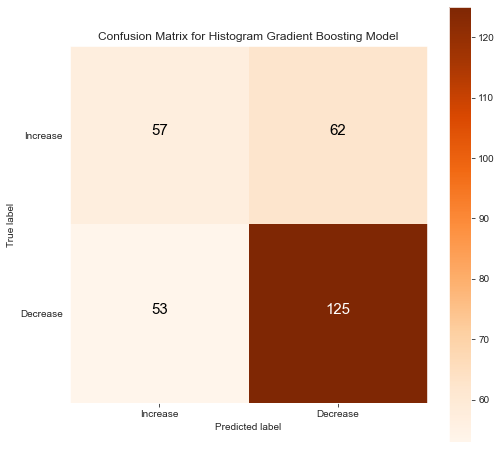

In [12]:
make_confusion_matrix(y_true=increase, y_pred=predicted_increase,classes=["Increase", "Decrease"],title="Confusion Matrix for Histogram Gradient Boosting Model", cmap=plt.cm.Oranges, figsize=(8,8))

In [13]:
save_model(model=clf, filename="baseline_imputed.joblib")